In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from tqdm import tqdm_notebook
from keras.models import Model,load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout,BatchNormalization,Activation,Dense,Flatten,Add,AveragePooling2D
from keras import backend as K
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
training_data=pd.read_json('train.json')

In [3]:
training_data['data'].shape
#read data from prepared json file

(10000,)

In [4]:
train_data=np.array(training_data['data'][0:int(training_data.shape[0]*4/5)].tolist())
train_label=np.array(training_data['labels'][0:int(training_data.shape[0]*4/5)].tolist())
val_data=np.array(training_data['data'][int(training_data.shape[0]*4/5):(training_data.shape[0])].tolist())
val_label=np.array(training_data['labels'][int(training_data.shape[0]*4/5):(training_data.shape[0])].tolist())
#split data in to training set and validation set as 4:1

In [5]:
train_data.shape

(8000, 3072)

In [6]:
ffin=[]
fin=[]
tmp=[];
ttmp=[];
for i in train_data:
    for k in range(32):
        for j in range(32):
            ttmp.append(i[k*32+j]/255.0)
            ttmp.append(i[k*32+j+1024]/255.0)
            ttmp.append(i[k*32+j+2048]/255.0)
            tmp.append(ttmp)
            ttmp=[]
        fin.append(tmp)
        tmp=[]
    ffin.append(fin)
    fin=[]

train_data=np.array(ffin)

#convert train_data from 1x3072 into 32x32x3

In [7]:
ffin=[]
fin=[]
tmp=[];
ttmp=[];
for i in val_data:
    for k in range(32):
        for j in range(32):
            ttmp.append(i[k*32+j]/255.0)
            ttmp.append(i[k*32+j+1024]/255.0)
            ttmp.append(i[k*32+j+2048]/255.0)
            tmp.append(ttmp)
            ttmp=[]
        fin.append(tmp)
        tmp=[]
    ffin.append(fin)
    fin=[]
    
val_data=np.array(ffin)
ffin=[]

#convert val_data from 1x3072 into 32x32x3

In [8]:
val_label[0]

1

In [9]:
train_label=np_utils.to_categorical(train_label, 2)
val_label=np_utils.to_categorical(val_label, 2)
#convert label into hot code

In [10]:
train_label.shape

(8000, 2)

In [11]:
input_layer=Input((32,32,3))
'''
c0 = Conv2D(16, (3, 3), activation='relu', padding='same') (input_layer)
c0 = Conv2D(16, (3, 3), activation='relu', padding='same') (c0)
p0 = Dropout(0.3) (c0)

c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (p0)
c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (c1)
c1 = Conv2D(16, (3, 3), activation='relu', padding='same') (c1)
p1 = Dropout(0.3) (c1)
p1=MaxPooling2D()(p1)

c2 = Conv2D(32, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(32, (3, 3), activation=None, padding='same') (c2)
rc2 = BatchNormalization()(c2)
rc2 = Activation('relu')(rc2)
rc2 = Conv2D(32, (3, 3), activation='relu', padding='same') (rc2)
rc2 = Conv2D(32, (3, 3), activation='relu', padding='same') (rc2)
rc2 = Add() ([c2,rc2])
p2 = Dropout(0.5) (rc2)

c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(64, (3, 3), activation=None, padding='same') (c3)
rc3 = BatchNormalization()(c3)
rc3 = Activation('relu')(rc3)
rc3 = Conv2D(64, (3, 3), activation='relu', padding='same') (rc3)
rc3 = Conv2D(64, (3, 3), activation='relu', padding='same') (rc3)
p2 = Dropout(0.5) (rc3)


c3 = Conv2D(64, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(64, (3, 3), activation=None, padding='same') (c3)
rc3 = BatchNormalization()(c3)
rc3 = Activation('relu')(rc3)
rc3 = Conv2D(64, (3, 3), activation='relu', padding='same') (rc3)
rc3 = Conv2D(64, (3, 3), activation='relu', padding='same') (rc3)

p2 = Dropout(0.5) (rc3)


c3 = Conv2D(128, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(128, (3, 3), activation=None, padding='same') (c3)
rc3 = BatchNormalization()(c3)
rc3 = Activation('relu')(rc3)
rc3 = Conv2D(128, (3, 3), activation='relu', padding='same') (rc3)
rc3 = Conv2D(128, (3, 3), activation='relu', padding='same') (rc3)

'''
nerual=16       #64 is worse than above network

fconv=Conv2D(64, (7, 7), strides=(2,2),activation='relu', padding='same') (input_layer)

c0 = Conv2D(nerual, (3, 3), activation='relu', padding='same') (fconv)
c0 = Conv2D(nerual, (3, 3), activation='relu', padding='same') (c0)
p0 = Dropout(0.1) (c0)

c1 = Conv2D(nerual, (3, 3), activation='relu', padding='same') (p0)
c1 = Conv2D(nerual, (3, 3), activation='relu', padding='same') (c1)
c1 = Conv2D(nerual, (3, 3), activation='relu', padding='same') (c1)
p1 = Dropout(0.1) (c1)
p1=MaxPooling2D()(p1)

c2 = Conv2D(nerual*2, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(nerual*2, (3, 3), activation=None, padding='same') (c2)
rc2 = BatchNormalization()(c2)
rc2 = Activation('relu')(rc2)
rc2 = Conv2D(nerual*2, (3, 3), activation='relu', padding='same') (rc2)
rc2 = Conv2D(nerual*2, (3, 3), activation='relu', padding='same') (rc2)
#rc2 = Add() ([c2,rc2])
p2 = Dropout(0.5) (rc2)

c3 = Conv2D(nerual*2, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(nerual*2, (3, 3), activation=None, padding='same') (c3)
rc3 = BatchNormalization()(c3)
rc3 = Activation('relu')(rc3)
rc3 = Conv2D(nerual*2, (3, 3), activation='relu', padding='same') (rc3)
rc3 = Conv2D(nerual*2, (3, 3), activation='relu', padding='same') (rc3)
#rc3 = Add() ([c3,rc3])
p2 = Dropout(0.5) (rc3)

c3 = Conv2D(nerual*4, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(nerual*4, (3, 3), activation=None, padding='same') (c3)
rc3 = BatchNormalization()(c3)
rc3 = Activation('relu')(rc3)
rc3 = Conv2D(nerual*4, (3, 3), activation='relu', padding='same') (rc3)
rc3 = Conv2D(nerual*4, (3, 3), activation='relu', padding='same') (rc3)
#rc3 = Add() ([c3,rc3])
p2 = Dropout(0.5) (rc3)

c3 = Conv2D(nerual*4, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(nerual*4, (3, 3), activation=None, padding='same') (c3)
rc3 = BatchNormalization()(c3)
rc3 = Activation('relu')(rc3)
rc3 = Conv2D(nerual*4, (3, 3), activation='relu', padding='same') (rc3)
rc3 = Conv2D(nerual*4, (3, 3), activation='relu', padding='same') (rc3)
#rc3 = Add() ([c3,rc3])
p2 = Dropout(0.5) (rc3)

c3 = Conv2D(nerual*8, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(nerual*8, (3, 3), activation=None, padding='same') (c3)
rc3 = BatchNormalization()(c3)
rc3 = Activation('relu')(rc3)
rc3 = Conv2D(nerual*8, (3, 3), activation='relu', padding='same') (rc3)
rc3 = Conv2D(nerual*8, (3, 3), activation='relu', padding='same') (rc3)

flatten1 = Flatten()(rc3)
dense = Dense(units=2, kernel_initializer="he_normal",
                      activation="softmax")(flatten1)


model=Model(inputs=input_layer,output=dense)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


#Two Network models are tried. The fisrt is simple CNN with dropout. Second is a larger Network with ResNet shortcut.

/home/wenjie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:111: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


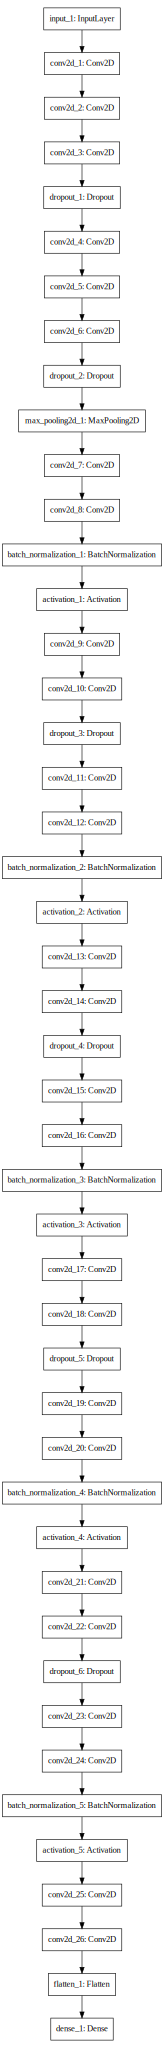

In [12]:

plot_model(model, to_file='model.png',show_shapes=True)
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
train_data.shape

(8000, 32, 32, 3)

In [ ]:
lr_reduce = ReduceLROnPlateau(factor=0.1, cooldown=0, patience=5, min_lr=0.5e-6)
early_stop = EarlyStopping(min_delta=0.001, patience=15)
checkpoint = ModelCheckpoint("./Seconf_net_no_shortcut.model", save_best_only=True, verbose=1)

model.fit(train_data, train_label,
              batch_size=32,
              epochs=100,
              validation_data=(val_data, val_label),
              callbacks=[lr_reduce, early_stop,checkpoint])


Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 5s 618us/step - loss: 0.6767 - acc: 0.5772 - val_loss: 0.6729 - val_acc: 0.6665

Epoch 00001: val_loss improved from inf to 0.67293, saving model to ./Seconf_net_no_shortcut.model
Epoch 2/100
8000/8000 [==============================] - 3s 427us/step - loss: 0.6241 - acc: 0.6611 - val_loss: 0.7354 - val_acc: 0.5545

Epoch 00002: val_loss did not improve from 0.67293
Epoch 3/100
8000/8000 [==============================] - 3s 380us/step - loss: 0.5861 - acc: 0.6943 - val_loss: 0.6101 - val_acc: 0.6690

Epoch 00003: val_loss improved from 0.67293 to 0.61014, saving model to ./Seconf_net_no_shortcut.model
Epoch 4/100
8000/8000 [==============================] - 3s 395us/step - loss: 0.5588 - acc: 0.7212 - val_loss: 0.6681 - val_acc: 0.6120

Epoch 00004: val_loss did not improve from 0.61014
Epoch 5/100
8000/8000 [==============================] - 3s 385us/step - loss: 0.5385 - acc: 0.7

In [ ]:
#model=load_model('./simplest_more_filters.model')

In [ ]:
plot_model(model, to_file='simplest_model.png',show_shapes=True)
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
testing_data=pd.read_json('test.json')
test_data=np.array(testing_data['data'][0:int(testing_data.shape[0]*4/5)].tolist())
ffin=[]
fin=[]
tmp=[];
ttmp=[];
for i in test_data:
    for k in range(32):
        for j in range(32):
            ttmp.append(i[k*32+j]/255.0)
            ttmp.append(i[k*32+j+1024]/255.0)
            ttmp.append(i[k*32+j+2048]/255.0)
            tmp.append(ttmp)
            ttmp=[]
        fin.append(tmp)
        tmp=[]
    ffin.append(fin)
    fin=[]

test_data=np.array(ffin)
ffin=[]
#get test_data in 32x32x3 format

In [ ]:
test_data.shape

In [ ]:
test_label=np.array(testing_data['labels'][0:int(testing_data.shape[0]*4/5)].tolist())
test_label=np_utils.to_categorical(test_label, 2)

In [ ]:
print(test_label[0:10])
print(np.argmax(test_label,axis=1)[0:10])

In [ ]:
prediction=model.predict(test_data)
prediction=np.argmax(prediction,axis=1)

In [ ]:

test_label=np.argmax(test_label,axis=1)

In [ ]:
ra=0
wa=0
for i in range(len(prediction)):
    if prediction[i]==test_label[i]:
        ra+=1
    else:
        wa += 1
print(ra)
print(wa)
print(1.0*ra/(ra+wa))